In [329]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn


sizeFixed = (64,64)
channels = 3
#dsImages = "/home/digits/jupyter/chtseng/datasets/office/train"
dsImages = "/export/home/digits/jupyter/chtseng/datasets/classed/actions2/train"

epoch = 60
batchSize = 16
#testPath = "/home/digits/jupyter/chtseng/datasets/office/test"
testPath = "/export/home/digits/jupyter/chtseng/datasets/classed/actions2/test"

In [330]:
import os
from keras.models import Sequential # Initialise our neural network model as a sequential network
from keras.layers import Conv2D # Convolution operation
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector.
from keras.layers import Dense # Perform the full connection of the neural network
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import PReLU
# Imports
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from keras.layers.normalization import BatchNormalization
from datetime import datetime
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from keras.layers import Dropout
from IPython.display import display
from PIL import Image
from keras.layers import Dense, Dropout
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline

from keras import optimizers
import glob

In [331]:
#Lable的對應, 每個Lable對應到一個數值

#dict_labels = {"nobody": 0,"body": 1, "chair": 2, "head": 3}
#dict_labels = { "none": 0,"sitting": 1, "standing": 2, "walking": 3 }
dict_labels = { "none": 0,"body": 1, "empty": 2 }

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [332]:
def reshaped_image(image):
    return transform.resize(image,(sizeFixed[0], sizeFixed[1], channels)) # (cols (width), rows (height)) and don't use np.resize()

def load_images_from_folder(folder):    
    labels = []
    images = []
    
    for folders in glob.glob(folder+"/*"):
        #print("Load {} ...".format(folders))
        label = os.path.basename(folders)

        for filename in os.listdir(folders):  

            if label is not None:
                #print(dict_labels[label])
                img = cv2.imread(os.path.join(folder,folders,filename))
                if img is not None:            
                    img = reshaped_image(img)
                    labels.append(dict_labels[label])
                    images.append(np.array(img))
                    
    return np.array(images), np.array(labels)

def train_test_split(train_data, train_labels, fraction):
    index = int(len(train_data)*fraction)
    return train_data[:index], train_labels[:index], train_data[index:], train_labels[index:]

In [333]:
def cnnModel(size, n_layers):

    # INPUTS
    # size     - size of the input images
    # n_layers - number of layers
    # OUTPUTS
    # model    - compiled CNN
    # Define hyperparamters

    MIN_NEURONS = 20
    MAX_NEURONS = 120
    KERNEL = (3, 3)
    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)

    # Define a model
    model = Sequential()
    # Add convolutional layers
    for i in range(0, n_layers):
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))

        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Dropout(rate=0.25))
        model.add(BatchNormalization())
        model.add(Activation('sigmoid'))

    # Add max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.5))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))

    # Add output layer
    model.add(Dense(len(dict_labels)))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])

    # Print a summary of the model
    model.summary()

    return model

In [334]:
import h5py
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, merge, Activation, ZeroPadding2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization

def FireModule(s_1x1, e_1x1, e_3x3, name):
    """
        Fire module for the SqueezeNet model. 
        Implements the expand layer, which has a mix of 1x1 and 3x3 filters, 
        by using two conv layers concatenated in the channel dimension. 
        Returns a callable function
    """
    def layer(x):
        squeeze = Convolution2D(s_1x1, 1, 1, activation='relu', init='he_normal', name=name+'_squeeze')(x)
        squeeze = BatchNormalization(name=name+'_squeeze_bn')(squeeze)
        # Set border_mode to same to pad output of expand_3x3 with zeros.
        # Needed to merge layers expand_1x1 and expand_3x3.
        expand_1x1 = Convolution2D(e_1x1, 1, 1, border_mode='same', activation='relu', init='he_normal', name=name+'_expand_1x1')(squeeze)
        # expand_1x1 = BatchNormalization(name=name+'_expand_1x1_bn')(expand_1x1)

        # expand_3x3 = ZeroPadding2D(padding=(1, 1), name=name+'_expand_3x3_padded')(squeeze)
        expand_3x3 = Convolution2D(e_3x3, 3, 3, border_mode='same', activation='relu', init='he_normal', name=name+'_expand_3x3')(squeeze)
        # expand_3x3 = BatchNormalization(name=name+'_expand_3x3_bn')(expand_3x3)

        expand_merge = merge([expand_1x1, expand_3x3], mode='concat', concat_axis=3, name=name+'_expand_merge')
        return expand_merge
    return layer
    


def SqueezeNet(nb_classes, input_shape=(227, 227, 3)): 
    # Use input shape (227, 227, 3) instead of the (224, 224, 3) shape cited in the paper. 
    # This results in conv1 output shape = (None, 111, 111, 96), same as in the paper. 
    input_image = Input(shape=input_shape)
    conv1 = Convolution2D(96, 7, 7, activation='relu', subsample=(2, 2), init='he_normal', name='conv1')(input_image)
    # conv1 = BatchNormalization(name='conv1_bn')(conv1)
    # maxpool1 output shape = (?, 55, 55, 96)
    maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool1')(conv1)

    # fire2 output shape = (?, 55, 55, 128)
    fire2 = FireModule(s_1x1=16, e_1x1=64, e_3x3=64, name='fire2')(maxpool1)
    # fire3 output shape = (?, 55, 55, 128)
    fire3 = FireModule(s_1x1=16, e_1x1=64, e_3x3=64, name='fire3')(fire2)
    # fire4 output shape = (?, 55, 55, 256)
    fire4 = FireModule(s_1x1=32, e_1x1=128, e_3x3=128, name='fire4')(fire3)
    # maxpool4 output shape = (?, 27, 27, 256)
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool4')(fire4)
    # fire5 output shape = (?, 27, 27, 384)
    fire5 = FireModule(s_1x1=32, e_1x1=128, e_3x3=128, name='fire5')(maxpool4)
    # fire6 output shape = (?, 27, 27, 384)
    fire6 = FireModule(s_1x1=48, e_1x1=192, e_3x3=192, name='fire6')(fire5)
    # fire7 output shape = (?, 27, 27, 384)
    fire7 = FireModule(s_1x1=48, e_1x1=192, e_3x3=192, name='fire7')(fire6)
    # fire8 output shape = (?, 27, 27, 512)
    fire8 = FireModule(s_1x1=64, e_1x1=256, e_3x3=256, name='fire8')(fire7)
    # maxpool8 output shape = (?, 13, 13, 384). The paper states this output is (13, 13, 512)?
    maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool8')(fire7)
    # fire9 output shape = (?, 13, 13, 512)
    fire9 = FireModule(s_1x1=64, e_1x1=256, e_3x3=256, name='fire9')(maxpool8)
    # Dropout after fire9 module.
    fire9_dropout = Dropout(p=0.5, name='fire9_dropout')(fire9)

    # conv10 output shape = (?, 13, 13, 6)
    conv10 = Convolution2D(nb_classes, 1, 1, activation='relu', init='he_normal', name='conv10')(fire9_dropout)
    conv10 = BatchNormalization(name='conv10_bn')(conv10)
    # avgpool10, softmax output shape = (?, nb_classes)
    avgpool10 = GlobalAveragePooling2D(name='avgpool10')(conv10)
    # avgpool10 = AveragePooling2D(pool_size=(13, 13), strides=(1, 1), name='avgpool10')(conv10)
    # avgpool10 = Flatten(name='flatten')(avgpool10)
    softmax = Activation('softmax', name='softmax')(avgpool10)

    model = Model(input=input_image, output=[softmax])
    model.summary()
    
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy', 'categorical_crossentropy'])
    
    return model

In [335]:

#Usage:

# model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
# model.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])


from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])



In [336]:
def mnist1(size):
    import keras
    
    shape = (size[0], size[1], size[2])
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=shape))
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.20))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(len(dict_labels), activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

    return model

In [351]:
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

train_data, train_labels = load_images_from_folder(dsImages)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

fraction = 0.75
print("{}".format(train_data.shape))
print("{}".format(train_labels.shape))
train_data, train_labels, test_data, test_labels = train_test_split(train_data, train_labels, fraction)
datagen.fit(train_data)
#datagen.fit(test_data)

print("--> {}".format( test_data.shape))
print("--> {}".format( test_labels.shape))

train_labels = np_utils.to_categorical(train_labels, len(dict_labels))
test_labels = np_utils.to_categorical(test_labels, len(dict_labels))

train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0
print ("Train data size: ", len(train_data))
print ("Test data size: ", len(test_data))

#cnn = mnist1(size=np.asarray([sizeFixed[0], sizeFixed[1], channels]))
cnn = cnnModel(size=np.asarray([sizeFixed[0], sizeFixed[1], channels]), n_layers=2)
#cnn = SqueezeNet(len(dict_labels), input_shape=([sizeFixed[0], sizeFixed[1], 3]))

#Resnet
#cnn = ResnetBuilder.build_resnet_101((3, sizeFixed[0], sizeFixed[1]), len(dict_labels))
#cnn.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])
#end Resnet

#VGG16
#cnn = VGG16([sizeFixed[0], sizeFixed[1]], len(dict_labels), trained=False)


print ("Train data shape: ", train_data.shape)
print ("Test data shape: ", test_data.shape)
#idx = np.random.permutation(train_data.shape[0])
#print("idx=", idx)

#cnn.fit_generator(datagen.flow(train_data,train_labels, batch_size=batchSize), 
    #steps_per_epoch=round(len(train_data)/batchSize),epochs=epoch, validation_data=(test_data, test_labels))

h = cnn.fit_generator(datagen.flow(train_data,train_labels, batch_size=batchSize),
                              epochs = epoch, validation_data = (test_data,test_labels),
                              verbose = 1, steps_per_epoch=train_data.shape[0] // batchSize
                              , callbacks=[learning_rate_reduction],)

(24000, 64, 64, 3)
(24000,)
--> (6000, 64, 64, 3)
--> (6000,)
Train data size:  18000
Test data size:  6000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_497 (Conv2D)          (None, 62, 62, 20)        560       
_________________________________________________________________
dropout_158 (Dropout)        (None, 62, 62, 20)        0         
_________________________________________________________________
batch_normalization_437 (Bat (None, 62, 62, 20)        80        
_________________________________________________________________
activation_530 (Activation)  (None, 62, 62, 20)        0         
_________________________________________________________________
conv2d_498 (Conv2D)          (None, 60, 60, 60)        10860     
_________________________________________________________________
dropout_159 (Dropout)        (None, 60, 60, 60)        0         
__________________________________

KeyboardInterrupt: 

In [ ]:
finaltest_data, finaltest_labels = load_images_from_folder(testPath)
#finaltest_labels = np_utils.to_categorical(finaltest_labels, len(dict_labels))

finaltest_data = finaltest_data.astype('float32') / 255.0
predicted_test_labels = np.argmax(cnn.predict(finaltest_data), axis=1)

print ("Actual test labels:", finaltest_labels)
print ("Predicted test labels:", predicted_test_labels)
print ("Accuracy score:", accuracy_score(finaltest_labels, predicted_test_labels))

In [ ]:
# serialize model to JSON
model_json = cnn.to_json()
with open("body_64.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("body_64.h5")
print("Saved model to disk")

In [348]:
finaltest_labels = np_utils.to_categorical(finaltest_labels, len(dict_labels))
X_val = finaltest_data
Y_val = finaltest_labels

print(test_data.shape)
print(test_labels.shape)
print(finaltest_data.shape)
print(finaltest_labels.shape)

(6000, 64, 64, 3)
(6000, 3)
(3000, 64, 64, 3)
(3000, 3)


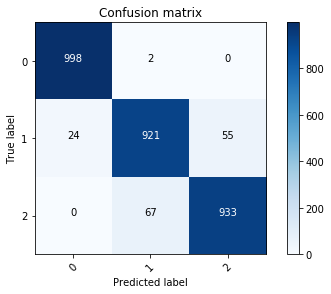

In [349]:
from sklearn.metrics import confusion_matrix
import itertools

# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(len(dict_labels)))

dict_keys(['val_acc', 'loss', 'val_loss', 'acc', 'lr'])


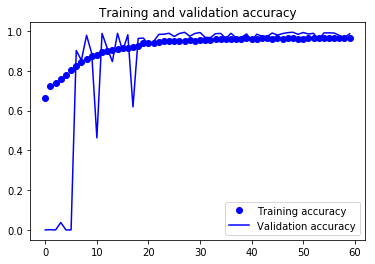

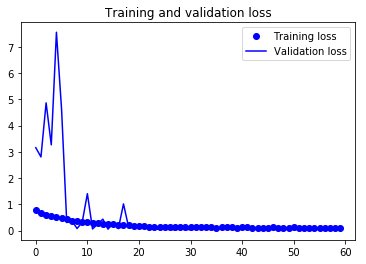

In [350]:
print(h.history.keys())
accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(1, 48, 48, 3)
[ 0.  0.  1.  0.]


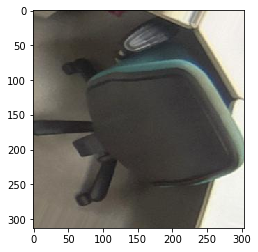

In [212]:
test_image = []
img = cv2.imread("/home/digits/jupyter/chtseng/datasets/office/test/chair/aug_0_2810.jpg")
#img = cv2.imread("/home/digits/jupyter/chtseng/datasets/classed/actions/test/sitting/126-4.jpg")
#img = cv2.imread("/home/digits/jupyter/chtseng/datasets/classed/actions/test/standing/90-1.jpg")

plt.imshow(img[...,::-1])
test_image.append(reshaped_image(img))
test_image = np.array(test_image)
print(test_image.shape)

#test_image = test_image.astype('float32') / 255.0
result = cnn.predict(test_image)
#img_class = cnn.predict_classes(test_image)
#prediction = img_class[0]
print(result[0])
#print( np.argmax(result, axis=1) )